In [2]:

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import json
import pickle
import gzip
import networkx as nx
from tqdm import tqdm
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept
import time
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs, sample_relevance_cavs, sample_bbox_cavs, sample_all_relevances_cavs

from expbasics.dim_reduction import visualize_dr, get_dr_methods, clean_centroids, centroid_distances
from expbasics.biased_noisy_dataset import get_biased_loader, BiasedNoisyDataset
from expbasics.test_dataset import TestDataset
from expbasics.causal_discovery import remove_empty, causal_discovery
from expbasics.ground_truth_measures import GroundTruthMeasures

from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid
from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.crp_attribution import CRPAttribution
from expbasics.network import load_model, train_network, accuracy_per_class
from measures0_to_2_new import AllMeasures


from expbasics.visualizations import sum_it, data_iterations, my_plot_grid

%reload_ext autoreload
%autoreload 2
plt.rcParams['text.usetex'] = True
matplotlib.rcParams.update({'font.family': 'serif', "font.size": 14})

In [26]:
""" ALL_MEASURES = [
    "m0_rho",
    "m0_mi",
    "m0_phi",
    "m1_mi",
    "m1_phi",
    "m1_mlc_abs",
    "m1_mlc_cosine",
    "m2_rel_abs",
    "m2_rel_euclid",
    "m2_rel_cosine",
    "m2_mac_abs",
    "m2_mac_euclid",
    "m2_mac_euclid_weighted",
    "m2_mac_cosine",
    "m2_mac_angular",
    "m2_mac_euclid_per_image",
    "m2_mac_kernel",
    "m2_rma_sum",
    "m2_rma_weighted",
    "m2_pg_sum",
    "m2_pg_weighted",
    "m2_rra_sum",
    "m2_rra_weighted",
    "m2_bbox_rel",
    "m2_rel_kernel",
    "m1_mlc_kernel",
] """

ALL_MEASURES = [
    "m1_phi",
    "m1_mlc_abs",
    "m1_mlc_cosine",
    "m1_mlc_euclid",
    "m1_mlc_l2square",
    "m2_rel_abs",
    "m2_rel_cosine",
    "m2_rel_euclid",
    "m2_rel_l2square",
    "m2_mac_abs",
    "m2_mac_euclid",
    "m2_mac_cosine",
    "m2_mac_l2square",
    "m2_rma",
    "m2_bbox_rel",
    "m2_pg_weighted",
    "m2_rra_weighted",
]

NAME_DICT = {
    "m0_rho": "Coupling Ratio $\\rho$ ($m_0$)",
    "m0_mi": "MI $corr(S,W)$ ($m_0$)",
    "m0_phi": "$\\phi$-correlation $corr(S,W)$ ($m_0$)",
    "m1_mi": "MI $corr(y,W)$ ($m_1$)",
    "m1_phi": "$\\phi$-correlation $corr(y,W)$ ($m_1$)",
    "m1_mlc_abs": "MLC absolute (= euclid) ($m_1$)",
    "m1_mlc_euclid": "MLC euclid (= absolute) ($m_1$)",
    "m1_mlc_cosine": "MLC cosine ($m_1$)",
    "m2_rel_abs": "Relevance Vector absolute ($m_2$)",
    "m2_rel_euclid": "Relevance Vector euclid ($m_2$)",
    "m2_rel_cosine": "Relevance Vector cosine ($m_2$)",
    "m2_rel_l2square": "Relevance Vector L2-Norm kernelized ($m_2$)",
    "m2_mac_abs": "MAC absolute ($m_2$)",
    "m2_mac_euclid": "MAC euclid ($m_2$)",
    "m2_mac_euclid_weighted": "MAC euclid weighted ($m_2$)",
    "m2_mac_cosine": "MAC cosine ($m_2$)",
    "m2_mac_angular": "MAC angular ($m_2$)",
    "m2_mac_euclid_per_image": "MAC euclid per image ($m_2$)",
    "m2_mac_l2square": "MAC Squared L2-Norm kernelized ($m_2$)",
    "m2_rma": "RMA for all concepts ($m_2$)",
    "m2_rma_weighted": "RMA weighted ($m_2$)",
    "m2_pg_sum": "Pointing Game average ($m_2$)",
    "m2_pg_weighted": "Pointing Game weighted ($m_2$)",
    "m2_rra_sum": "RRA average ($m_2$)",
    "m2_rra_weighted": "RRA weighted ($m_2$)",
    "m2_bbox_rel": "Relevance within bounding box ($m_2$)",
    "m2_rel_kernel": "Relevance Vector kernel ($m_2$)",
    "m1_mlc_l2square": "MLC Squared L2-Norm kernelized ($m_1$)",
}

ms = AllMeasures(
    "../dsprites-dataset/images/",
)

In [52]:
random_predictions = ms.rng.random((51, 16, ms.len_x, 1, 2, 2))
predv_0 = torch.tensor(random_predictions[0, 0, 2, :, 0])
print(predv_0)
int(predv_0.data.max(1)[1][0])

model = load_model("../clustermodels/final",0.9, 0)
img = ms.ds.load_image_wm(5,True)
model(img)

tensor([[0.8874, 0.5561]], dtype=torch.float64)


tensor([[ 4.4586, -3.6451]], grad_fn=<AddmmBackward0>)

In [181]:
rho_ind = 50
m = 2
filename = f"outputs/attribution_output/{rho_ind}_{m}.gz"
with gzip.open(filename, mode="rb") as f:
    r_m_info = pickle.load(f)
pred0s = r_m_info[1][:, 0].to(dtype=torch.float)
pred1s = r_m_info[1][:, 1].to(dtype=torch.float)
permuted = np.zeros((256,2))
permuted[:128] = pred0s
permuted[128:] = pred1s
ms.rng.shuffle(permuted, axis=0)
permuted = torch.from_numpy(permuted).view(128,1,2,2)


In [221]:
torch.mean(per_sample[49,:,:,15])


tensor(0.2279)

torch.Size([51, 16, 4])


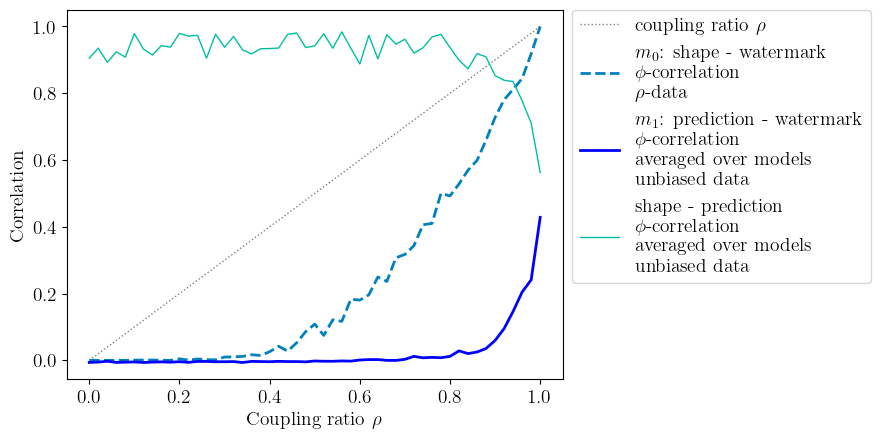

In [224]:
# Ground Truth

biases = list(np.round(np.linspace(0, 1, 51), 3))
with open("m1_mi_6400.pickle", "rb") as f:
    m1_mi = pickle.load(f)
with open("gt_measures_1280.pickle", "rb") as f: #gt_measures_1280
    gt_measures = pickle.load(f)
with open("shape_gt_6400.pickle", "rb") as f:
    shape_gt = pickle.load(f)
mimean = torch.mean(m1_mi, dim=1)
print(gt_measures.shape)

""" plt.plot(biases, torch.mean(shape_gt[:,:,0], dim=1),linewidth=2, label="MI shape", color="#f90", alpha=0.5)
plt.plot(biases, gt_measures[:,0,0],linewidth=2, label="MI true label - watermark", linestyle="dashed", color="#f00")
plt.plot(biases, torch.mean(gt_measures[:,:,2], dim=1),linewidth=1, label="MI (distribution rho) true label - watermark", linestyle="dotted", color="#f55")
plt.plot(biases, mimean[:,0],linewidth=2, label="MI (data unbiased) prediction - watermark", color="#f00") """
ecol = matplotlib.cm.winter(np.linspace(0, 1, 5))
plt.plot(biases, biases,linewidth=1, label="coupling ratio $\\rho$", linestyle="dotted", color="gray")
plt.plot(biases, torch.mean(gt_measures[:,:,0], dim=1),linewidth=2, label="$m_0$: shape - watermark\n $\\phi$-correlation \n $\\rho$-data", linestyle="dashed", color=ecol[2])
#plt.plot(biases, torch.mean(gt_measures[:,:,3], dim=1),linewidth=1, label="(distribution rho) prediction - watermark", linestyle="dotted", color=ecol[2])
plt.plot(biases, mimean[:,1],linewidth=2, label="$m_1$: prediction - watermark\n $\\phi$-correlation \n averaged over models \n unbiased data", color=ecol[0])
plt.plot(biases, torch.mean(shape_gt[:,:,1], dim=1),linewidth=1, label="shape - prediction\n $\\phi$-correlation \n averaged over models \n unbiased data", color=ecol[3])


plt.ylabel("Correlation")
plt.xlabel("Coupling ratio $\\rho$")
plt.legend(
        bbox_to_anchor=(1.0, 0.924, 1.0, 0.102),
        loc="upper left",
        ncols=1,)
#(0., -0.53, 1., .102)

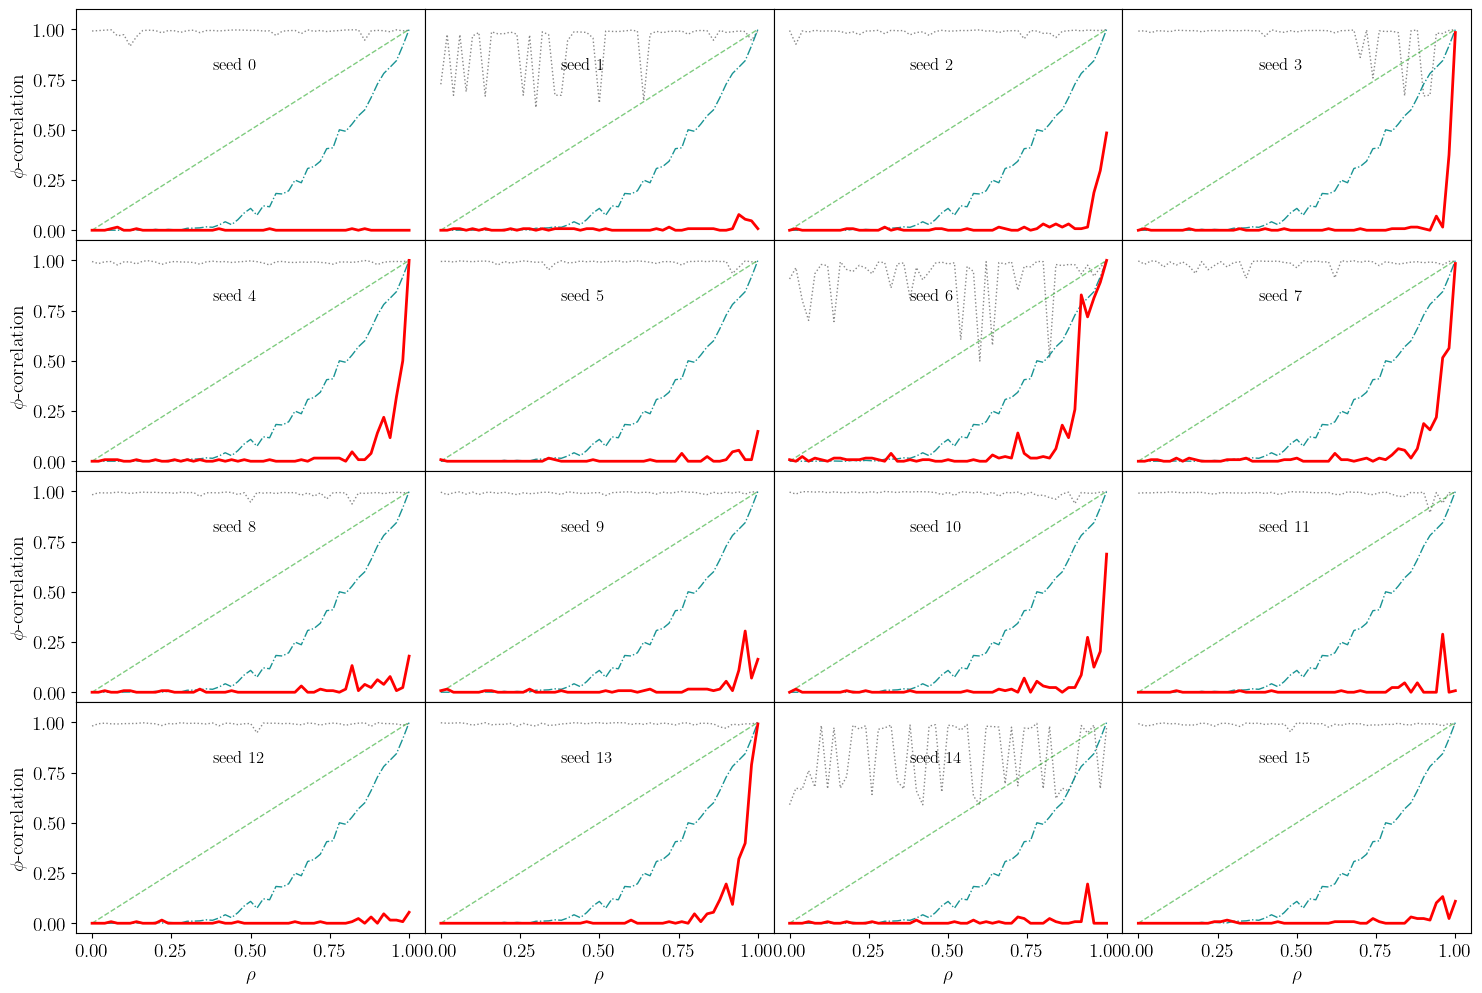

In [226]:
# MI and PHI over seeds

with open("pf_128.pickle", "rb") as f:
    m1_mi = pickle.load(f)
    
with open("outputs/retrain.json", "r") as jf:
    accuracies = json.load(jf)

def to_name(b, i):
    return "b{}-i{}".format(
        str(round(b, 2)).replace(".", "_"),
        str(i),
    )
     
biases = list(np.round(np.linspace(0, 1, 51), 3))
fig, axs = plt.subplots(
        4,
        4,
        figsize=(
            18,
            12,
        ),
        gridspec_kw={"wspace": 0.0, "hspace": 0},
    )
for s in range(16):
    names = [to_name(b, s) for b in biases]
    accuracy = np.array([accuracies[n]["train_accuracy"][2]/ 100 for n in names])
    axs[s //4, s % 4].set_ylim([-0.05, 1.1])
    axs[s //4, s % 4].set_xlabel("$\\rho$")
    axs[s //4, s % 4].set_ylabel("$\\phi$-correlation")
    if s // 4 != 3 :
        axs[s //4, s % 4].xaxis.set_visible(False)
    if s % 4 != 0:
        axs[s //4, s % 4].yaxis.set_visible(False)
    axs[s //4, s % 4].text(
        0.38, 0.8,
        f"seed {s}",
        size=12,
    )
    axs[s //4, s % 4].plot(biases, accuracy,linewidth=1,linestyle="dotted", label="accuracy", color="#888")
    axs[s //4, s % 4].plot(biases, biases,linewidth=1, label="coupling ratio $\\rho$", linestyle="dashed", color="#090", alpha=0.5)
    axs[s //4, s % 4].plot(biases, torch.mean(gt_measures[:,:,0], dim=1),linewidth=1, label="shape - watermark\n$\\phi$-correlation", linestyle="dashdot", color="#088", alpha=0.9)
    axs[s //4, s % 4].plot(biases, m1_mi[:,s,1],linewidth=2, label="MI (data unbiased) prediction - watermark", color="#f00")

In [231]:
with gzip.open("all_measures_128_random.pickle", "rb") as f:
    per_sample = pickle.load(f)

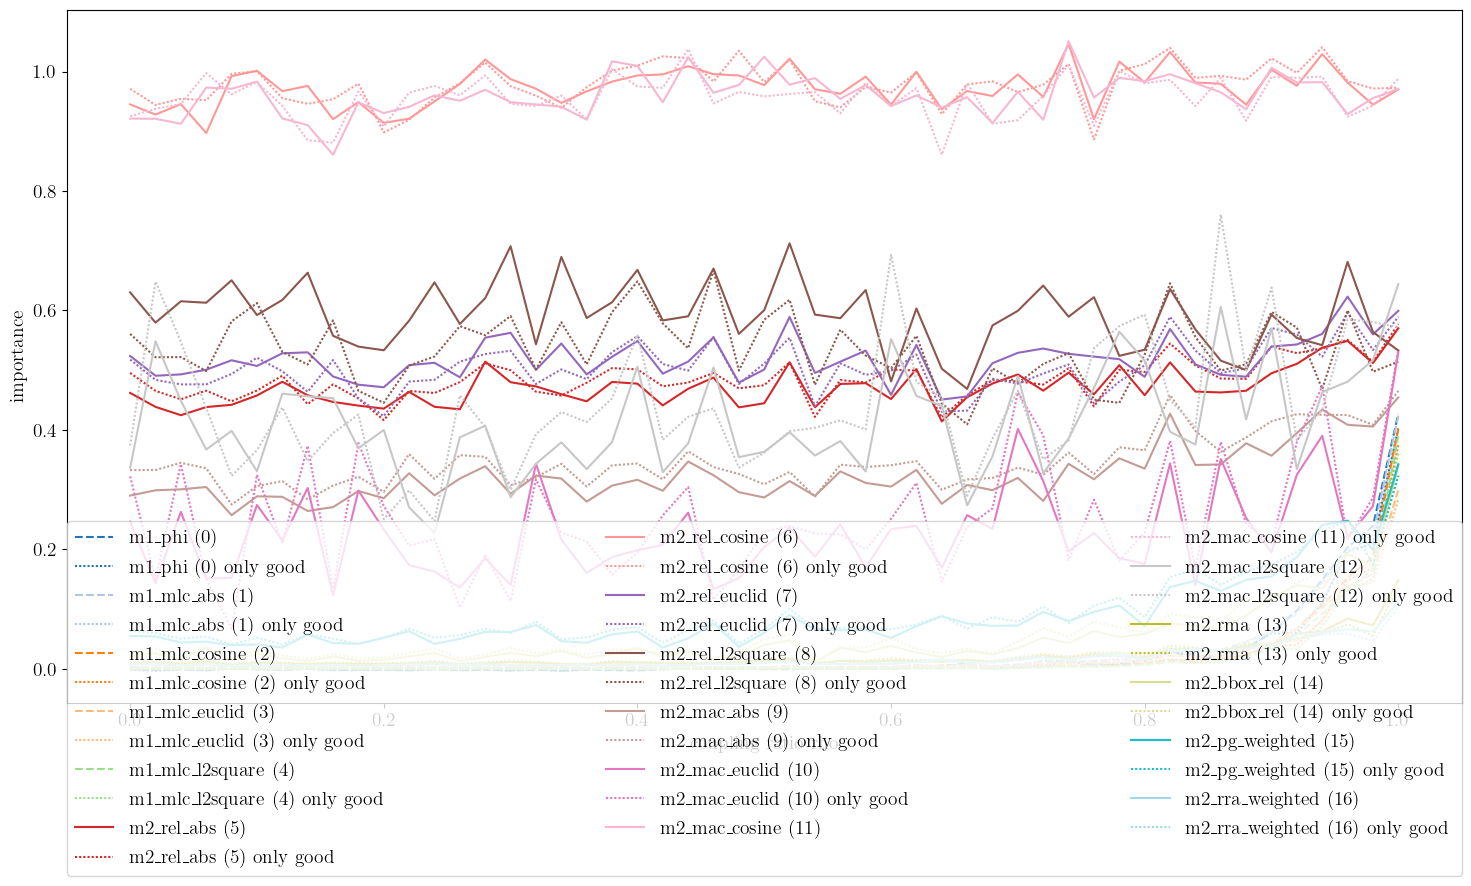

In [36]:
# FILTER BAD OUT
def filter_bad_out(data):
    filtered = torch.zeros(51,12,128,17)
    c = 0
    for num_it in range(16):
        if num_it not in [6,14, 1,3,]: #1,3,
            filtered[:, c] = data[:,num_it,:,:]
            c+=1
    return filtered
filtered = filter_bad_out(per_sample)

biases = list(np.round(np.linspace(0, 1, 51), 3))
takeing = range(0,17)
ls = ["dotted", "dashed", "solid"]
per_rho = torch.mean(per_sample, dim=(1,2))
per_rho_good = torch.mean(filtered, dim=(1,2))
#normalized = per_rho / torch.max(per_rho, dim=0).values

colors = matplotlib.cm.tab20(np.linspace(0, 1, len(takeing)))
use_m = []
plt.figure(figsize=(18,9))
for en, i in enumerate(takeing):
    #for s in range(16):
    l = ALL_MEASURES[i]
    label = f"{l} ({i})" #if s == 0 else ""
    vals = per_rho[:,i] 
    vals_good = per_rho_good[:,i]

    if  l: #.startswith("m2_mac") #"bbox" in l or "kernel" in
        plt.plot(
            biases,
            vals,
            label=label,
            linestyle=ls[int(l[1])],
            c=colors[en],
        )  
        plt.plot(
            biases,
            vals_good,
            label=f"{label} only good",
            linestyle=(0, (1, 1)),
            c=colors[en],
        ) 

#plt.title("All measures summed over samples and seeds")
plt.ylabel("importance")
plt.xlabel("coupling ratio rho")
plt.legend(bbox_to_anchor=(0., -0.25, 1., .102), loc='lower left',
                      ncols=3, mode="expand", borderaxespad=0.)


'     [\n        "m1_phi",\n        "m1_mlc_l2square",\n        "m1_mlc_abs",\n        "m2_bbox_rel",\n        "m2_rma",\n        "m2_mac_l2square",\n    ], '

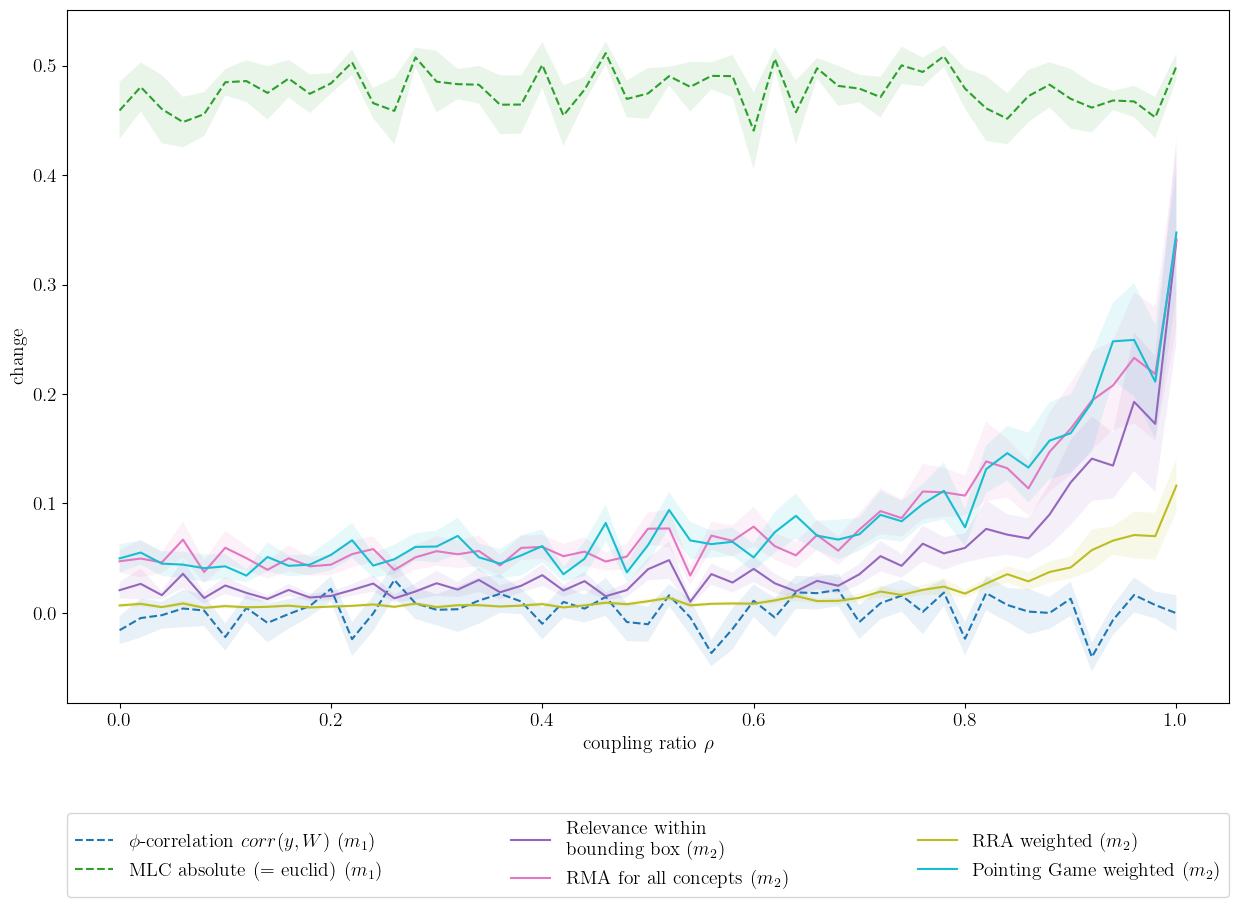

In [232]:
# SHOW CERTAIN MEASURES
import collections.abc


def draw_measures(per_sample, ptype="all", with_title=False):
    variable_options = {
        # "m0": [range(0,3), "data distribution for only 128 samples $m_0$", "correlation", -0.14,3],
        "m1": [
            [0, 1, 2, 3, 4],
            "Ground Truth Model Importance $m_1$",
            "model importance $m_1$",
            -0.18,
            3,
        ],
        "m2": [
            range(5, 17),
            "Mean Attribution Change (comparing distance metrics) $m_2$",
            "MAC $m_2$",
            -0.33,
            3,
        ],
        "m2_mac": [
            range(9, 13),
            "Mean Attribution Change (comparing distance metrics) $m_2$",
            "MAC $m_2$",
            -0.23,
            3,
        ],
        "m2_region": [
            range(13, 17),
            "Region specific metrics $m_2$",
            "region-specific change $m_2$",
            -0.23,
            3,
        ],
        "m2_rel": [
            [5, 6, 7, 8],
            "Relevance Vector (comparing distance metrics) $m_2$",
            "relevance vector change $m_2$",
            -0.18,
            2,
        ],
        "abs": [
            [1, 5, 9],
            "Absolute Measures $m_2$",
            "absolute change $m_2$",
            -0.22,
            3,
        ],
        "kernel": [
            [4, 8, 12],
            "Kernelized Treatment Effect $m_2$",
            "kernelized change $m_2$",
            -0.14,
            3,
        ],
        "euclid": [
            [3, 7, 10],
            "Euclidean Distance Measures $m_2$",
            "euclidean change $m_2$",
            -0.18,
            3,
        ],
        "cosine": [
            [2, 6, 11],
            "Cosine Distance Measures $m_2$",
            "cosine change $m_2$",
            -0.14,
            4,
        ],
        "all": [
            range(len(ALL_MEASURES)),
            "All Measures $m_0,m_1,m_2$",
            "all measures",
            -0.48,
            3,
        ],
        "chosen": [
            [0, 4, 8, 12, 13, 14, 15, 16],
            "All Chosen Metrics",
            "all",
            -0.33,
            3,
        ],
    }

    if not isinstance(ptype, str) and isinstance(ptype, collections.abc.Sequence):
        plot_variables = [
            [ALL_MEASURES.index(n) for n in ptype],
            "comparison",
            "change",
            -0.14 * (len(ptype) // 3),
            3,
        ]
    elif ptype in variable_options:
        plot_variables = variable_options[ptype]
    else:
        plot_variables = [
            [ALL_MEASURES.index(ptype)],
            NAME_DICT[ptype],
            "change",
            -0.14,
            1,
        ]
    biases = list(np.round(np.linspace(0, 1, 51), 3))
    used_measures = plot_variables[0]
    ls = ["dotted", "dashed", "solid"]
    per_seed = torch.mean(per_sample, dim=2)  # filtered
    per_seed = per_seed
    colors = matplotlib.cm.tab10(np.linspace(0, 1, len(used_measures)))
    plt.figure(figsize=(15, 9))
    for en, i in enumerate(used_measures):
        l = ALL_MEASURES[i]
        label = NAME_DICT[l]
        linestyle = ls[int(l[1])]
        vals = torch.mean(per_seed[:, :, i], dim=1)
        sigma = torch.std(per_seed[:, :, i], dim=1) / math.sqrt(16)
        # vmin = torch.min(per_seed[:, :, i], dim=1).values
        # vmax = torch.max(per_seed[:, :, i], dim=1).values
        if l:
            plt.plot(
                biases,
                vals,
                label=label,
                linestyle=linestyle,
                c=colors[en],
            )

            plt.fill_between(
                biases,
                vals + sigma,
                vals - sigma,
                facecolor=colors[en],
                alpha=0.1,
            )
    if with_title:
        plt.title(plot_variables[1])
    plt.ylabel(plot_variables[2])
    plt.xlabel("coupling ratio $\\rho$")
    plt.legend(
        bbox_to_anchor=(0.0, plot_variables[3], 1.0, 0.102),
        loc="lower left",
        ncols=plot_variables[4],
        mode="expand",
        borderaxespad=0.0,
    )


draw_measures(
    per_sample,
    ["m1_phi","m1_mlc_abs","m2_bbox_rel","m2_rma", "m2_rra_weighted", "m2_pg_weighted" ]
)
"""     [
        "m1_phi",
        "m1_mlc_l2square",
        "m1_mlc_abs",
        "m2_bbox_rel",
        "m2_rma",
        "m2_mac_l2square",
    ], """

In [14]:
biases = torch.round(torch.linspace(0, 1, 51), decimals=3)
sm = torch.nn.Softmax(dim=0)
weights = sm(biases)
biases, weights

(tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
         0.1800, 0.2000, 0.2200, 0.2400, 0.2600, 0.2800, 0.3000, 0.3200, 0.3400,
         0.3600, 0.3800, 0.4000, 0.4200, 0.4400, 0.4600, 0.4800, 0.5000, 0.5200,
         0.5400, 0.5600, 0.5800, 0.6000, 0.6200, 0.6400, 0.6600, 0.6800, 0.7000,
         0.7200, 0.7400, 0.7600, 0.7800, 0.8000, 0.8200, 0.8400, 0.8600, 0.8800,
         0.9000, 0.9200, 0.9400, 0.9600, 0.9800, 1.0000]),
 tensor([0.0114, 0.0116, 0.0119, 0.0121, 0.0123, 0.0126, 0.0128, 0.0131, 0.0134,
         0.0136, 0.0139, 0.0142, 0.0145, 0.0148, 0.0151, 0.0154, 0.0157, 0.0160,
         0.0163, 0.0167, 0.0170, 0.0173, 0.0177, 0.0180, 0.0184, 0.0188, 0.0192,
         0.0195, 0.0199, 0.0203, 0.0208, 0.0212, 0.0216, 0.0220, 0.0225, 0.0229,
         0.0234, 0.0239, 0.0244, 0.0249, 0.0254, 0.0259, 0.0264, 0.0269, 0.0275,
         0.0280, 0.0286, 0.0292, 0.0298, 0.0304, 0.0310]))

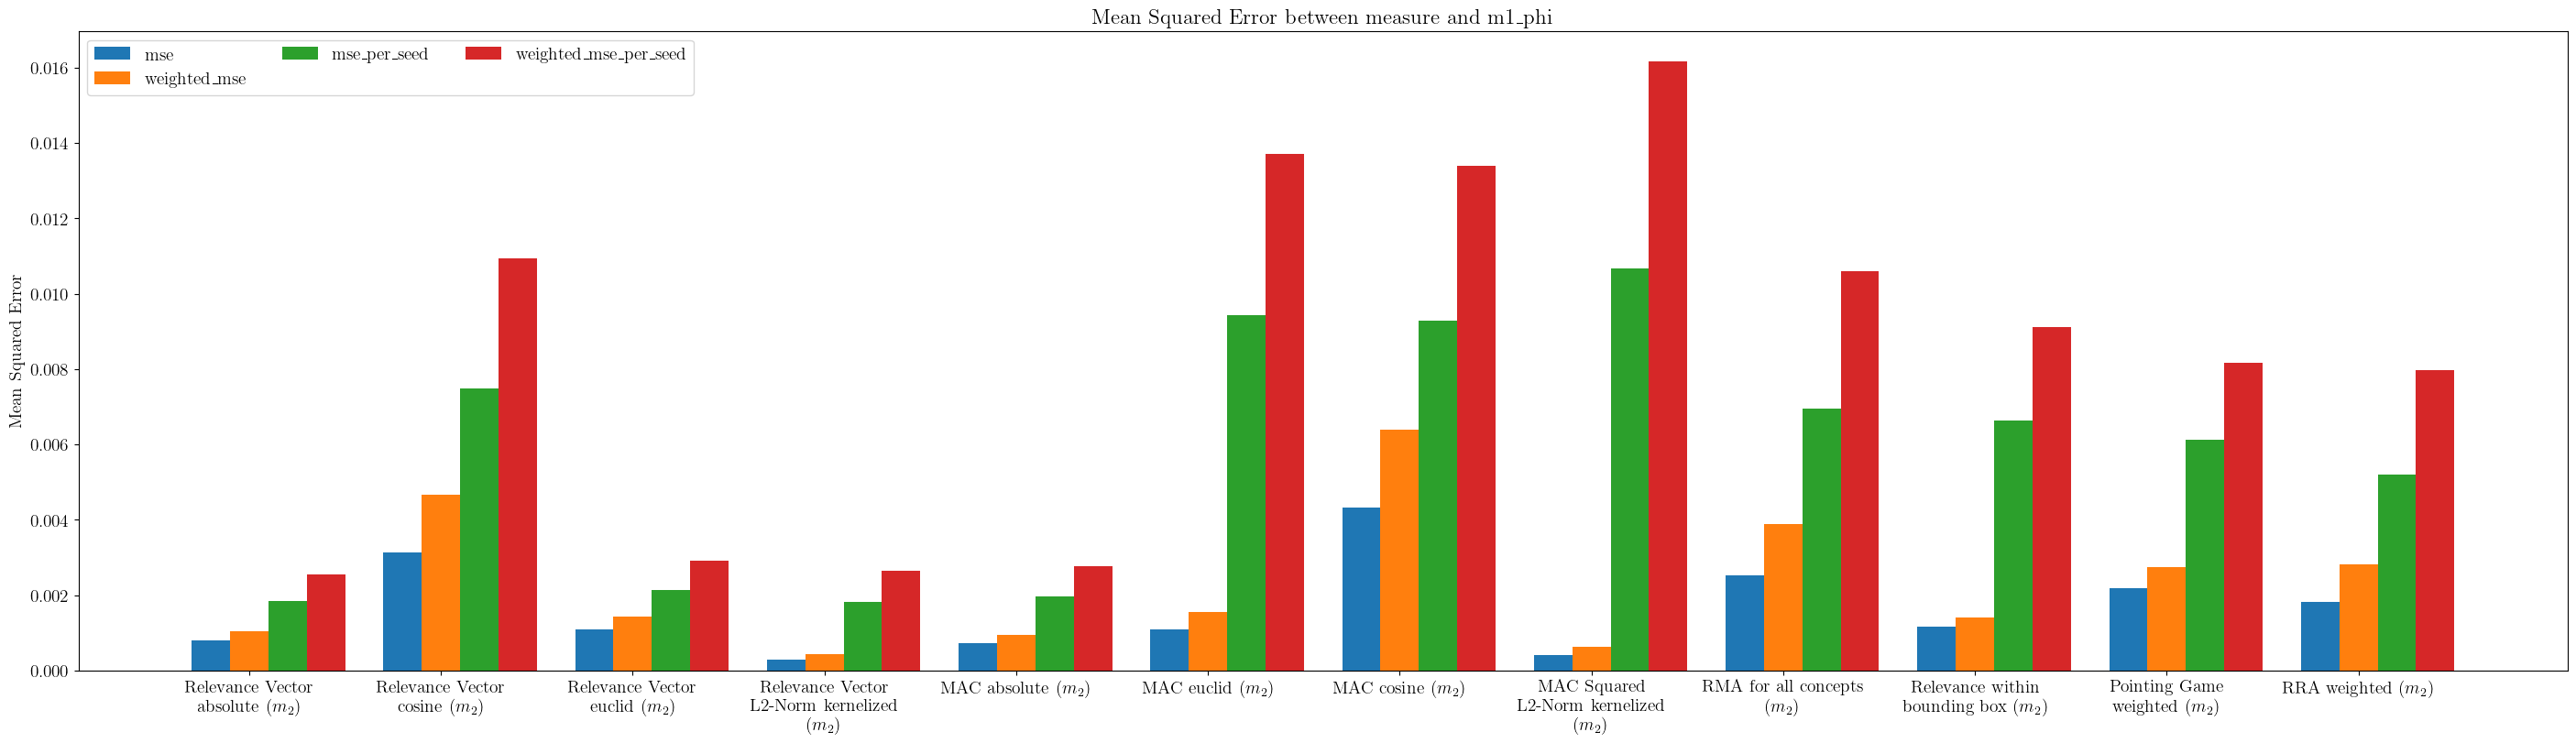

In [28]:
from textwrap import wrap

m1s = [
    "m1_phi",
    "m1_mlc_abs",
    "m1_mlc_cosine",
    "m1_mlc_euclid",
    "m1_mlc_l2square",
]

m2s = [
    "m2_rel_abs",
    "m2_rel_cosine",
    "m2_rel_euclid",
    "m2_rel_l2square",
    "m2_mac_abs",
    "m2_mac_euclid",
    "m2_mac_cosine",
    "m2_mac_l2square",
    "m2_rma",
    "m2_bbox_rel",
    "m2_pg_weighted",
    "m2_rra_weighted",
]


def mse(a, b):
    # return torch.nn.functional.mse_loss(a,b)
    return float(torch.mean(torch.square(a - b)))


def weighted_mse(a, b):
    if a.shape == (51, 16):
        return torch.sum(torch.square((a - b)) * weights[:, None]) / 16
    return torch.sum(torch.square((a - b)) * weights)  # torch.tensor(biases)


def r2_value(a, b):
    corr_matrix = np.corrcoef(a, b)  # actual, predict
    corr = corr_matrix[0, 1]
    R_sq = corr**2
    if np.isnan(R_sq):
        R_sq = 0.0
    return R_sq


mses = {}
for_plot = {
    "mse": [],
    "weighted_mse": [],
    "r2": [],
    "r2_per_seed": [],
    "mse_per_seed": [],
    "weighted_mse_per_seed": [],
}
per_rho = torch.mean(per_sample, dim=(1, 2))  # filtered
per_seed = torch.mean(per_sample, dim=(2))
m1_index = 0
m1_phi_vals = per_rho[:, m1_index]
m1_phi_valsps = per_seed[:, :, m1_index]
for measure in m2s:
    mk = ALL_MEASURES.index(measure)
    vals = per_rho[:, mk]
    mses[measure] = {
        "mse": mse(m1_phi_vals, vals),
        "weighted_mse": weighted_mse(m1_phi_vals, vals),
        "r2": r2_value(m1_phi_vals, vals),
        "r2_per_seed": r2_value(m1_phi_valsps.flatten(), per_seed[:, :, mk].flatten()),
        # torch.mean(torch.tensor([r2_value(m1_phi_valsps[:,s], per_seed[:, s, mk]) for s in range(16)])),
        "mse_per_seed": mse(m1_phi_valsps, per_seed[:, :, mk]),
        "weighted_mse_per_seed": weighted_mse(m1_phi_valsps, per_seed[:, :, mk]),
    }
    for_plot["mse"].append(mses[measure]["mse"])
    for_plot["weighted_mse"].append(mses[measure]["weighted_mse"])
    for_plot["r2"].append(mses[measure]["r2"])
    for_plot["r2_per_seed"].append(mses[measure]["r2_per_seed"])
    for_plot["mse_per_seed"].append(mses[measure]["mse_per_seed"])
    for_plot["weighted_mse_per_seed"].append(mses[measure]["weighted_mse_per_seed"])


x = np.arange(len(mses.keys()))  # the label locations
fig, ax = plt.subplots(layout="constrained", figsize=(28, 8))
width = 0.2  # the width of the bars
multiplier = 0
for attribute in ["mse", "weighted_mse", "mse_per_seed", "weighted_mse_per_seed"]:
    measurement = for_plot[attribute]
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title(f"Mean Squared Error between measure and {ALL_MEASURES[m1_index]}")
ax.set_ylabel("Mean Squared Error")
ax.set_xticks(x + width, ["\n".join(wrap(NAME_DICT[k], 20)) for k in mses.keys()])
ax.legend(loc="upper left", ncols=3)
# ax.set_ylim(0, 1)

In [7]:
ms.rng.integers(0,2,2)

array([1, 0])

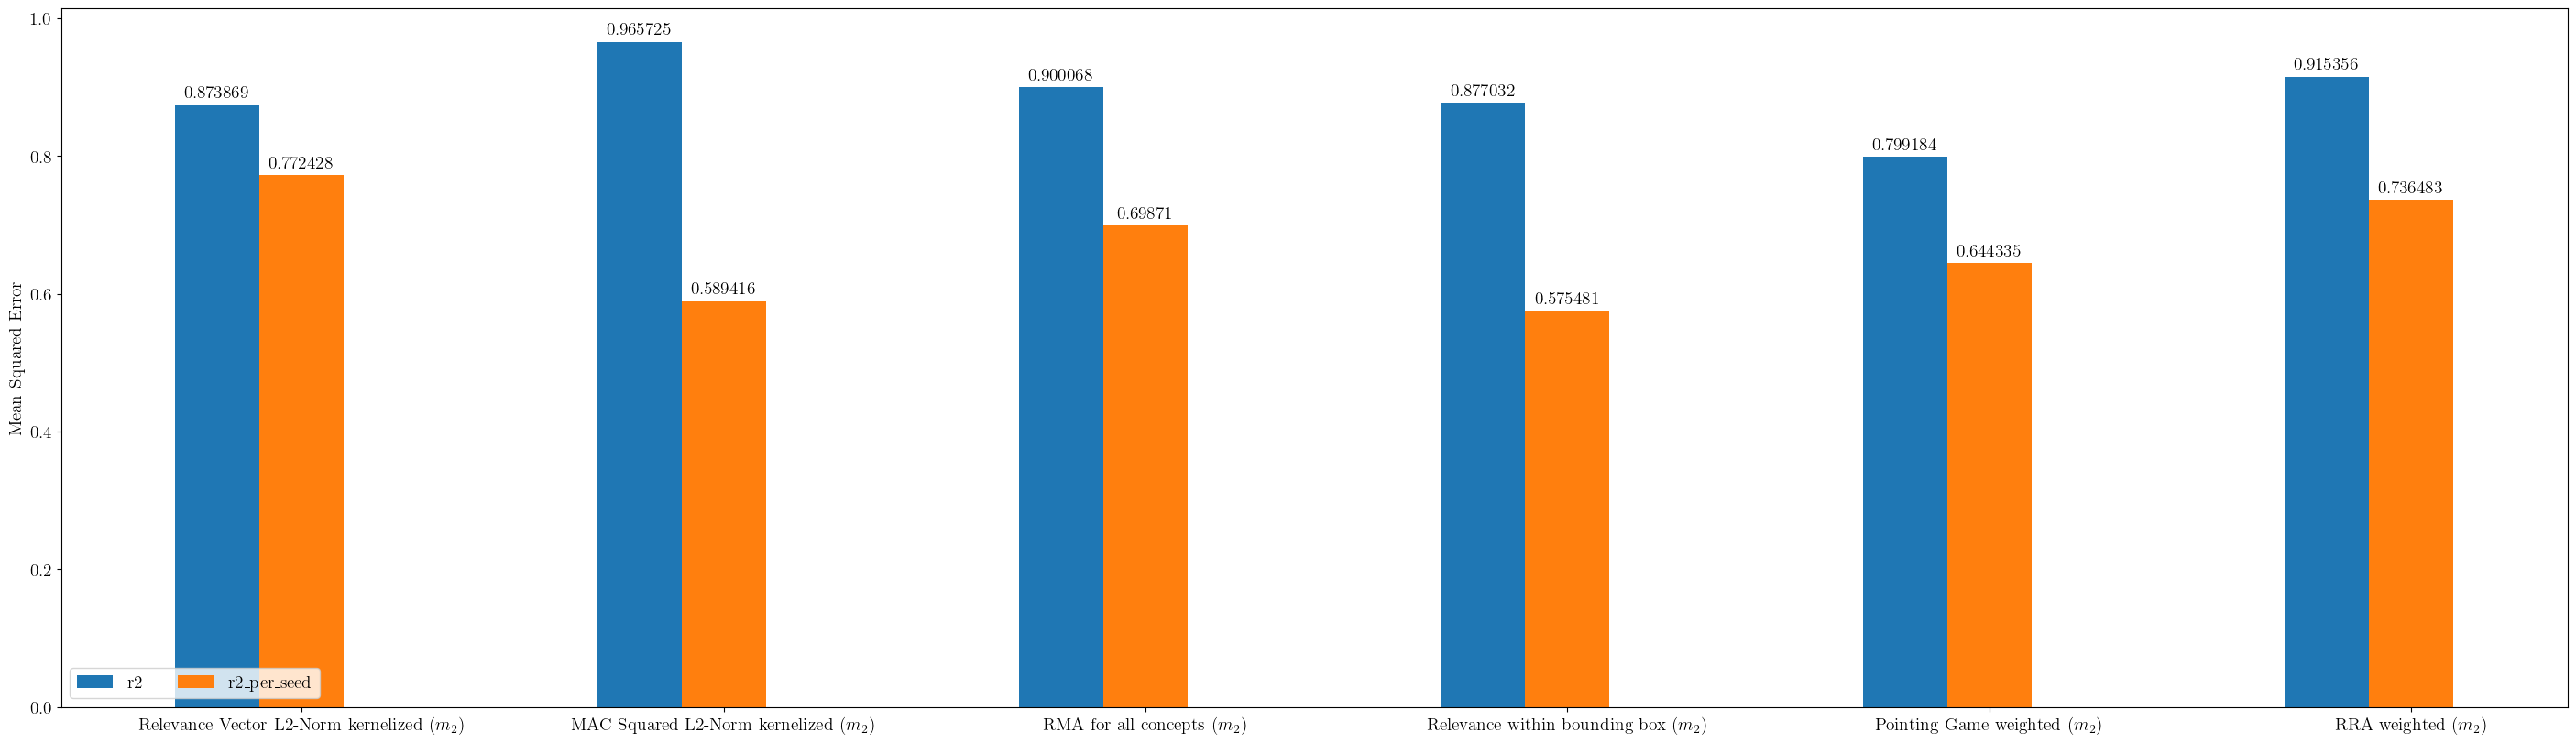

In [373]:

x = np.arange(len(mses.keys()))  # the label locations
fig, ax = plt.subplots(layout="constrained", figsize=(28, 8))
width = 0.2  # the width of the bars
multiplier = 0
for attribute in ["r2", "r2_per_seed"]:
    measurement = for_plot[attribute]
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Mean Squared Error")
ax.set_xticks(x + width, [NAME_DICT[k] for k in mses.keys()])
ax.legend(loc="lower left", ncols=3)
# ax.set_ylim(0, 1)

In [290]:
mses

{'m1_mlc_abs': {'mse': tensor(2.7059e-05),
  'r2': 0.9980596177256487,
  'l2_square_kernel': 0.00022883113706484437},
 'm1_mlc_cosine': {'mse': tensor(0.0002),
  'r2': 0.9847819905078857,
  'l2_square_kernel': 0.0005928673781454563},
 'm1_mlc_euclid': {'mse': tensor(nan), 'r2': 0.0, 'l2_square_kernel': nan},
 'm1_mlc_l2square': {'mse': tensor(0.0004),
  'r2': 0.971290946704588,
  'l2_square_kernel': 0.0010625323047861457},
 'm2_rel_abs': {'mse': tensor(0.0008),
  'r2': 0.9521267028363194,
  'l2_square_kernel': 0.0018390595214441419},
 'm2_rel_cosine': {'mse': tensor(0.0031),
  'r2': 0.9678337257264575,
  'l2_square_kernel': 0.007484091445803642},
 'm2_rel_euclid': {'mse': tensor(0.0011),
  'r2': 0.9450871449912748,
  'l2_square_kernel': 0.002132601337507367},
 'm2_rel_l2square': {'mse': tensor(0.0003),
  'r2': 0.9590475137360591,
  'l2_square_kernel': 0.0018131306860595942},
 'm2_mac_abs': {'mse': tensor(0.0007),
  'r2': 0.9510173453008649,
  'l2_square_kernel': 0.001975307473912835},


In [301]:
a = torch.rand(128,8) * 2 -1
b = torch.rand(128,8) * 2 -1

torch.any(torch.abs(torch.square(a-b)-(torch.square(a) - 2*a*b + torch.square(b))) > 0.0000001)



tensor(True)

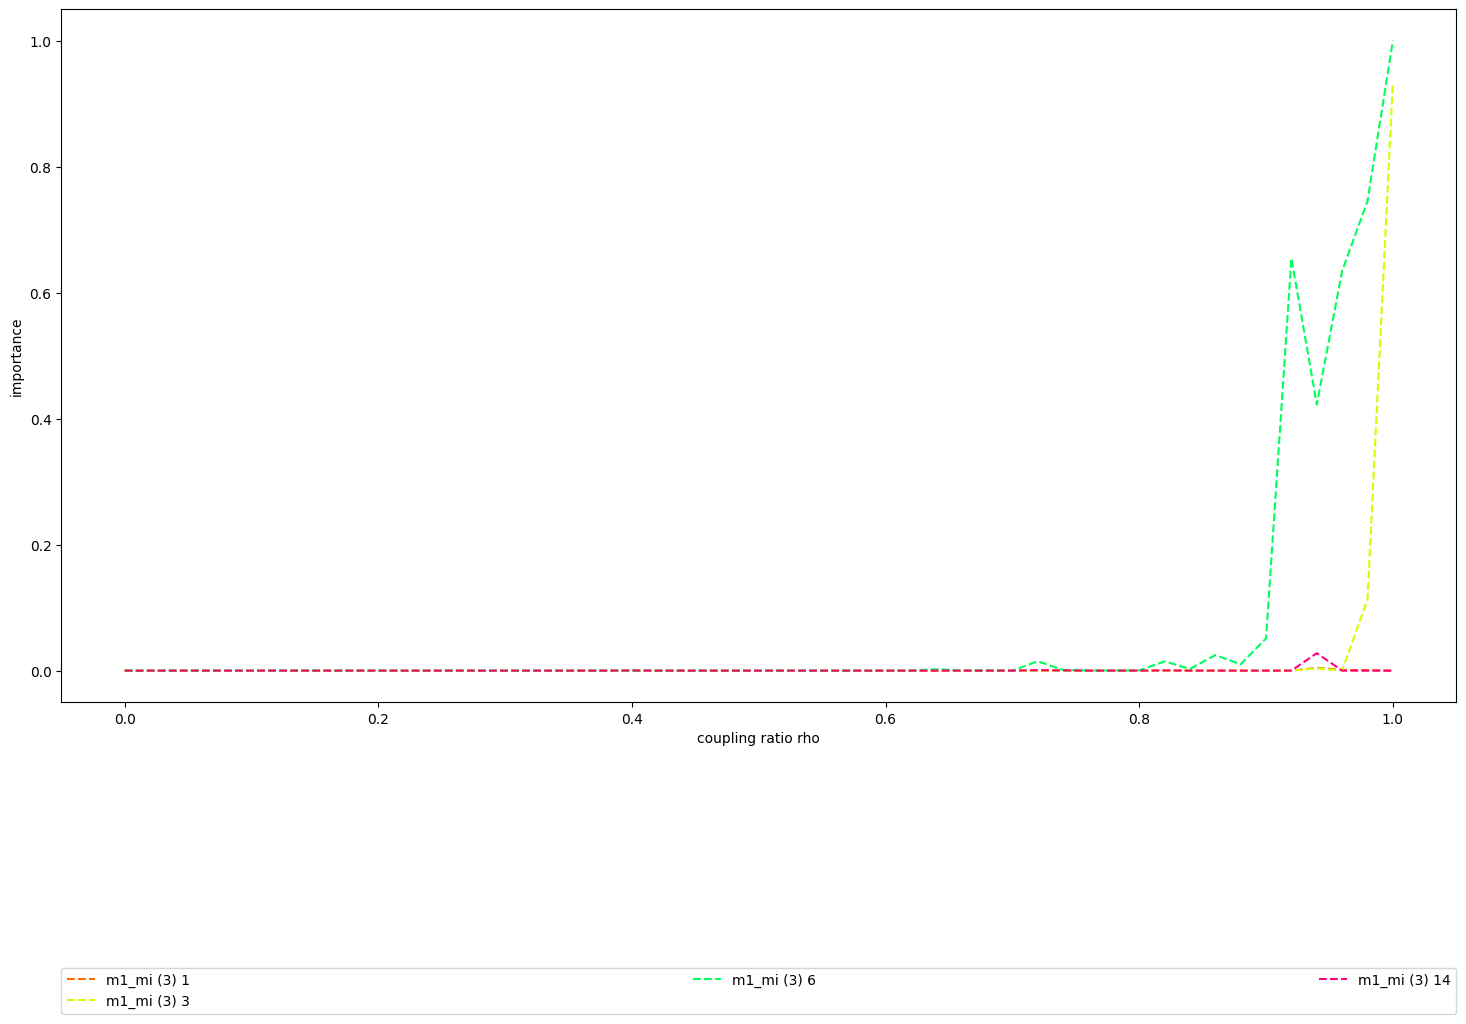

In [207]:
# MEASURES OVER SINGLE SEEDS

biases = list(np.round(np.linspace(0, 1, 51), 3))
takeing = [3]#,12,16,18, 20] #range(len(ALL_MEASURES))
ls = ["dotted", "dashed", "solid"]
per_rho = torch.mean(per_sample, dim=(2))

#colors = matplotlib.cm.tab20(np.linspace(0, 1, len(takeing)))
colors = matplotlib.cm.hsv(np.linspace(0, 1, 16))
use_m = []
plt.figure(figsize=(18,9))
for en, i in enumerate(takeing):
    for num in [1,3,6,14]:
        l = ALL_MEASURES[i]
        label = f"{l} ({i}) {num}"
        vals = per_rho[:,num, i] / enums[i][2] 
        if  l: #.startswith("m2_mac")
            plt.plot(
                biases,
                vals,
                label=label,
                linestyle=ls[int(l[1])],
                c=colors[num],
            )  

#plt.title("All measures summed over samples and seeds")
plt.ylabel("importance")
plt.xlabel("coupling ratio rho")
plt.legend(bbox_to_anchor=(0., -0.45, 1., .102), loc='lower left',
                      ncols=3, mode="expand", borderaxespad=0.)


In [37]:
per_sample = torch.zeros(
            (51, 16, 128, 26))
        
with gzip.open("all_measures_128_3.pickle", "rb") as f:
    old_values = pickle.load(f)
per_sample[:, :, :, :24] = old_values
with gzip.open("all_measures_128_4.pickle", "rb") as f:
    new_values = pickle.load(f)
per_sample[:, :, :, 24:] = new_values[:,:,:,24:]